In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from utils import train_and_plot_learning_curve
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
df = pd.read_csv('../data/features/train.csv', sep=';', index_col=0)

df['foundation_type'] = df['foundation_type'].astype('category')
df['concrete_code'] = df['concrete_code'].astype('category')
df['load_code'] = df['load_code'].astype('category')
df['wind_code'] = df['wind_code'].astype('category')
df['seismic_code'] = df['seismic_code'].astype('category')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654 entries, 0 to 1653
Data columns (total 78 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   foundation_type             1654 non-null   category
 1   concrete_code               1654 non-null   category
 2   load_code                   1654 non-null   category
 3   wind_code                   1654 non-null   category
 4   seismic_code                1654 non-null   category
 5   floor_number                1654 non-null   int64   
 6   total_height                1654 non-null   float64 
 7   height                      1654 non-null   float64 
 8   foundation_height           1654 non-null   float64 
 9   double_height               1654 non-null   float64 
 10  triple_height               1654 non-null   float64 
 11  support_column              1654 non-null   int64   
 12  unsupported_column          1654 non-null   int64   
 13  walls_number      

## Preparando los datos

In [4]:
hgbr_cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan))

hgbr_default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"))

hgbr_preprocessing = ColumnTransformer([
        ("cat", hgbr_cat_pipeline, make_column_selector(dtype_include='category')),
    ],
    remainder=hgbr_default_num_pipeline,
    verbose_feature_names_out=False,
) 

# Datos de entrada

In [5]:
df = df.drop(['center_x', 'center_y', 'cdm_x', 'cdm_y', 'cdr_x', 'cdr_y'], axis=1)

In [6]:
X = df.drop("reinf_steel_ratio", axis=1)
y = df["reinf_steel_ratio"].copy()

In [7]:
len(X.columns)

71

In [8]:
X.columns

Index(['foundation_type', 'concrete_code', 'load_code', 'wind_code',
       'seismic_code', 'floor_number', 'total_height', 'height',
       'foundation_height', 'double_height', 'triple_height', 'support_column',
       'unsupported_column', 'walls_number', 'retaining_walls_number',
       'support_area', 'walls_area', 'retaining_walls_area', 'LL', 'DL',
       'LL_max', 'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc',
       'slab_total_area', 'flat_slab_area', 'waffle_slab_area', 'depth',
       'drop_panel_area', 'domes_area', 'domes_number', 'inter_axis_distance',
       'shape_factor', 'x_length', 'y_length', 'concrete_m3_ratio',
       'slab_area_mean', 'height_mean', 'double_height_ratio',
       'triple_height_ratio', 'slenderness', 'column_area', 'swall_num',
       'swall_area', 'swall_area_mean', 'col_area_mean', 'rwalls_area_mean',
       'swall_area_mean_m2', 'col_area_mean_m2', 'rwalls_area_mean_m2',
       'swall_area_ratio', 'col_area_ratio', 'rwals_area_ratio', 

# Histogram-Based Gradient Boosting

In [9]:
categorical_columns = X.select_dtypes(include="category").columns
hgbr_reg = make_pipeline(hgbr_preprocessing,
                           HistGradientBoostingRegressor(categorical_features=categorical_columns, early_stopping=True, random_state=42)
                        ).set_output(transform="pandas")

In [10]:
%%time
hgbr_reg_mapes = cross_val_score(hgbr_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

CPU times: user 50.2 s, sys: 761 ms, total: 51 s
Wall time: 3.43 s


In [11]:
hgbr_reg_mapes

array([0.09317621, 0.07686533, 0.07889756, 0.08763831, 0.08539088,
       0.08639438, 0.08566679, 0.09917756, 0.08931974, 0.11165255])

In [12]:
pd.Series(hgbr_reg_mapes).describe()

count    10.000000
mean      0.089418
std       0.010081
min       0.076865
25%       0.085460
50%       0.087016
75%       0.092212
max       0.111653
dtype: float64

CPU times: user 1.62 s, sys: 1.89 s, total: 3.51 s
Wall time: 18.1 s


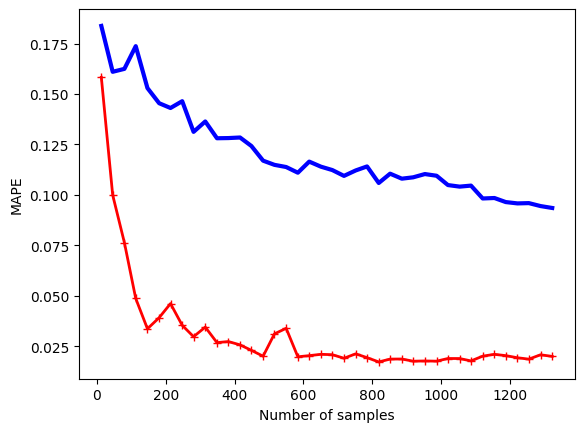

In [13]:
%%time
fig, ax = train_and_plot_learning_curve(hgbr_reg, X, y)
fig.savefig('../reports/figures/train/default_hgbr_cv.pdf', bbox_inches='tight')

# Grid Search

In [14]:
%%time

parameters = {
 'histgradientboostingregressor__learning_rate': [0.11, 0.12, 0.13],
 'histgradientboostingregressor__max_depth' : [43, 45, 47],
 'histgradientboostingregressor__max_leaf_nodes' : [21, 22, 23],
 'histgradientboostingregressor__min_samples_leaf' : [19, 20, 21],
 'histgradientboostingregressor__l2_regularization': [0.005, 0.01, 0.015],
 }
#instantiate the gridsearch
hgb_grid = GridSearchCV(hgbr_reg, parameters, n_jobs=-1, cv=10, scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))
#fit on the grid 
hgb_grid.fit(X, y)

CPU times: user 19.2 s, sys: 1.39 s, total: 20.6 s
Wall time: 5min 4s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median'))]),
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan))]),
                                                                         <s...
             param_grid={'histgradientboostingregressor__l2_regularization': [0.005,
                                                                              0.01,
                                                                              0.015],
                         'histgradientboostingregressor__learning_rate': [0.11,
                                                                          0.12,
                                                                          0.13],
                         'histgradientboostingregressor__max_depth': [43, 45,
                                                                      47],
                         'histgradientboostingregressor__max_leaf_nodes': [21,
                                                                           22,
                                                                           23],
                         'histgradientboostingregressor__min_samples_leaf': [19,
                                                                             20,
                                                                             21]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [15]:
hgb_grid.best_params_

{'histgradientboostingregressor__l2_regularization': 0.005,
 'histgradientboostingregressor__learning_rate': 0.12,
 'histgradientboostingregressor__max_depth': 43,
 'histgradientboostingregressor__max_leaf_nodes': 22,
 'histgradientboostingregressor__min_samples_leaf': 20}

# Best Model

In [16]:
best_params = {key.split('__')[-1]: value for key, value in hgb_grid.best_params_.items()}
best_params

{'l2_regularization': 0.005,
 'learning_rate': 0.12,
 'max_depth': 43,
 'max_leaf_nodes': 22,
 'min_samples_leaf': 20}

In [17]:
%%time
categorical_columns = X.select_dtypes(include="category").columns
hgbr_reg = make_pipeline(hgbr_preprocessing,
                           HistGradientBoostingRegressor(categorical_features=categorical_columns, random_state=42, **best_params)
                        ).set_output(transform="pandas")
hgbr_reg_mapes = cross_val_score(hgbr_reg, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(hgbr_reg_mapes).describe()

CPU times: user 54.3 s, sys: 102 ms, total: 54.4 s
Wall time: 3.74 s


count    10.000000
mean      0.086744
std       0.010795
min       0.067852
25%       0.080094
50%       0.086253
75%       0.093238
max       0.105175
dtype: float64

CPU times: user 1.07 s, sys: 259 ms, total: 1.33 s
Wall time: 16.3 s


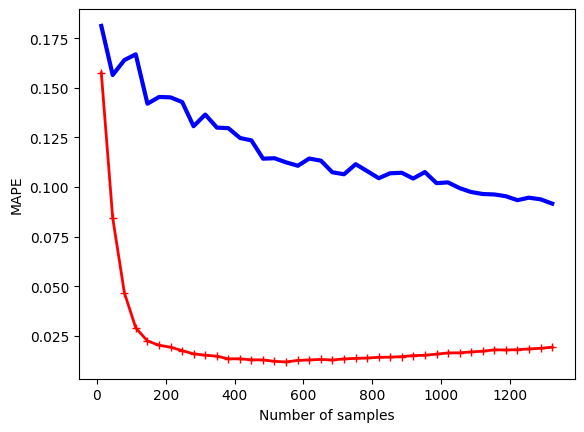

In [18]:
%%time
fig, ax = train_and_plot_learning_curve(hgbr_reg, X, y)
fig.savefig('../reports/figures/train/best_hgbr_cv.pdf', bbox_inches='tight')